In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt

from helpers.datasetHelper import get_samples, split_healthy_data
from pyswarm import pso

print("importing done")



importing done


In [ ]:
def load_methylation_data(file_path):
    """Main function to run the PSO feature selection with XGBoost"""
    # Load methylation data
    print("Loading DNA methylation data...")

    data_health = get_samples(file_path)

    # Load the PAN-CANCER-TRANSPOSED.csv data
    healthy_cases, prebrca_cases, cancer_cases = split_healthy_data(data_health)

    # Combine the data into a single dataframe
    # Tag each list of cases
    healthy_cases = pd.DataFrame(healthy_cases)
    healthy_cases['Tag'] = 'HEALTHY'
    prebrca_cases = pd.DataFrame(prebrca_cases)
    prebrca_cases['Tag'] = 'PRE-BRCA'
    cancer_cases = pd.DataFrame(cancer_cases)
    cancer_cases['Tag'] = 'BRCA'

    df_cancer = pd.concat([healthy_cases, prebrca_cases, cancer_cases], ignore_index=True) #blood samples
    # The last column is the target classes
    # Ensure all data is numeric
    X = df_cancer.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
    Y = df_cancer.iloc[:, -1]
    # Label encode the target variable
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y)

    # Extract feature names, exclude first column (sample names) and last column (target)
    feature_names = np.array(data_health[0])
    
    return X, Y, feature_names 

In [8]:

directory_path = './datasets'
data_path = os.path.join(directory_path, 'DT.Healthy.csv')

X, Y, columns = load_methylation_data(data_path)
print("Data loaded successfully.")
# Fill missing values with the lowest value of its cpg site
X = X.apply(lambda col: col.fillna(col.min()), axis=0)

feature_names = columns[0:-1]  # Display first 5 feature names for brevity

print(feature_names)  # Display first 5 feature names for brevity


Loading DNA methylation data...


/Users/leandro/master/Mamo.IA/helpers/datasetHelper.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257

Data loaded successfully.
['cg00000292' 'cg00002426' 'cg00003994' ... 'cg27662379' 'cg27662877'
 'cg27665659']


In [28]:
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score


def run_pso_with_progress(X, Y, estimator, n_features,
                          swarmsize=50, maxiter=10, threshold=0.7):
    lb = [0]*n_features
    ub = [1]*n_features
    progress = []

    # Create a scorer for Cohen's Kappa
    kappa_scorer = make_scorer(cohen_kappa_score)

    def objective_with_progress(weights, est, X_, Y_):
        Xw = X_ * weights
                
        # Use it in cross_val_score
        fit = 1 - cross_val_score(est, Xw, Y_, cv=5, scoring=kappa_scorer).mean()
        progress.append(fit)
        
        if len(progress) % 10 == 0:
            print(f"Eval {len(progress)}: best fitness so far = {min(progress):.4f}")
        return fit

    best_pos, best_fit = pso(
        objective_with_progress,
        lb, ub,
        args=(estimator, X, Y),
        swarmsize=swarmsize,
        maxiter=maxiter
    )

    mask = best_pos > threshold
    selected_features = np.where(mask)[0].tolist()
    return best_pos, best_fit, progress, selected_features


Loaded dataset with 27578 features and 790 samples
Eval 10: best fitness so far = 0.7642
Eval 20: best fitness so far = 0.7642
Eval 30: best fitness so far = 0.7642
Eval 40: best fitness so far = 0.7642
Eval 50: best fitness so far = 0.7642
Eval 60: best fitness so far = 0.6607
Eval 70: best fitness so far = 0.6607
Eval 80: best fitness so far = 0.6607
Eval 90: best fitness so far = 0.6607
Eval 100: best fitness so far = 0.6607
Eval 110: best fitness so far = 0.6607
Eval 120: best fitness so far = 0.6607
Eval 130: best fitness so far = 0.6607
Eval 140: best fitness so far = 0.6607
Eval 150: best fitness so far = 0.6607
Eval 160: best fitness so far = 0.6607
Eval 170: best fitness so far = 0.6607
Eval 180: best fitness so far = 0.6600
Eval 190: best fitness so far = 0.6600
Eval 200: best fitness so far = 0.6600
Eval 210: best fitness so far = 0.6408
Eval 220: best fitness so far = 0.6408
Eval 230: best fitness so far = 0.6408
Eval 240: best fitness so far = 0.6408
Eval 250: best fitness

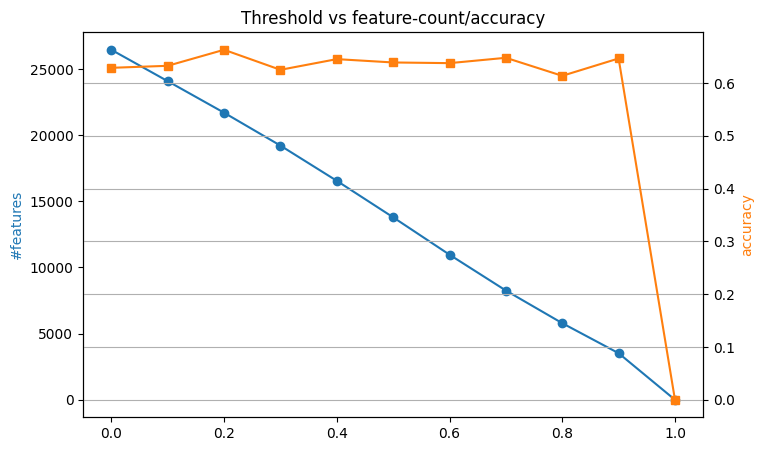

In [29]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

n_features = X.shape[1]
print(f"Loaded dataset with {n_features} features and {len(Y)} samples")

# Use DecisionTreeClassifier as the estimator
estimator = DecisionTreeClassifier(
    max_depth=None,  # Allow the tree to grow fully
    min_samples_split=2,  # Minimum samples required to split a node
    min_samples_leaf=1,  # Minimum samples required at a leaf node
    max_features='sqrt',  # Use a subset of features for splitting (sqrt of total features)
    random_state=42
)

# 2) Run PSO
best_weights, best_fitness, progress, X_selected = run_pso_with_progress(
    X, Y, estimator, n_features,
    swarmsize=50, maxiter=10
)
print(f"Done PSO → best fitness = {best_fitness:.4f}")

# 3) Threshold sweep
thresholds = np.linspace(0, 1, 11)
rows = []
for thr in thresholds:
    mask = best_weights > thr
    k = mask.sum()
    if k==0: 
        rows.append((thr, 0, 0.0))
        continue
    X_sel = X.iloc[:, mask]
    acc = cross_val_score(estimator, X_sel, Y, cv=5, scoring='accuracy').mean()
    rows.append((thr, k, acc, X_sel))

df_thr = pd.DataFrame(rows, columns=['threshold','n_features','accuracy', 'X_selected'])
print(df_thr)

# plot tradeoff
plt.figure(figsize=(8,5))
plt.plot(df_thr.threshold, df_thr.n_features, '-o', label='#features', color='C0')
plt.ylabel('#features', color='C0')
ax2 = plt.twinx()
ax2.plot(df_thr.threshold, df_thr.accuracy, '-s', label='accuracy', color='C1')
ax2.set_ylabel('accuracy', color='C1')
plt.xlabel('weight threshold')
plt.title('Threshold vs feature‐count/accuracy')
plt.grid(True)
plt.show()

[4, 10, 13, 16, 33, 34, 36, 42, 45, 47, 53, 55, 68, 69, 76, 82, 84, 87, 88, 91, 94, 95, 96, 99, 104, 107, 109, 112, 115, 118, 122, 128, 129, 130, 136, 138, 145, 148, 149, 151, 153, 157, 166, 168, 172, 174, 177, 179, 182, 184, 187, 195, 199, 201, 207, 216, 217, 218, 227, 231, 232, 235, 241, 242, 243, 244, 255, 256, 257, 260, 261, 263, 264, 269, 271, 273, 287, 288, 294, 295, 299, 301, 302, 312, 315, 316, 318, 320, 321, 322, 324, 325, 326, 331, 335, 336, 337, 341, 342, 343, 346, 354, 358, 360, 363, 365, 366, 370, 372, 377, 380, 382, 385, 388, 389, 392, 393, 395, 396, 398, 407, 413, 426, 433, 437, 438, 442, 447, 449, 452, 455, 463, 466, 467, 473, 475, 476, 481, 482, 483, 484, 487, 488, 489, 491, 496, 499, 509, 510, 514, 521, 529, 531, 540, 542, 543, 549, 550, 553, 555, 556, 561, 566, 567, 571, 573, 574, 576, 577, 579, 580, 581, 582, 583, 589, 592, 594, 604, 612, 613, 621, 622, 623, 626, 631, 634, 637, 640, 641, 644, 652, 654, 657, 659, 664, 667, 671, 674, 679, 680, 688, 689, 693, 695, 696,

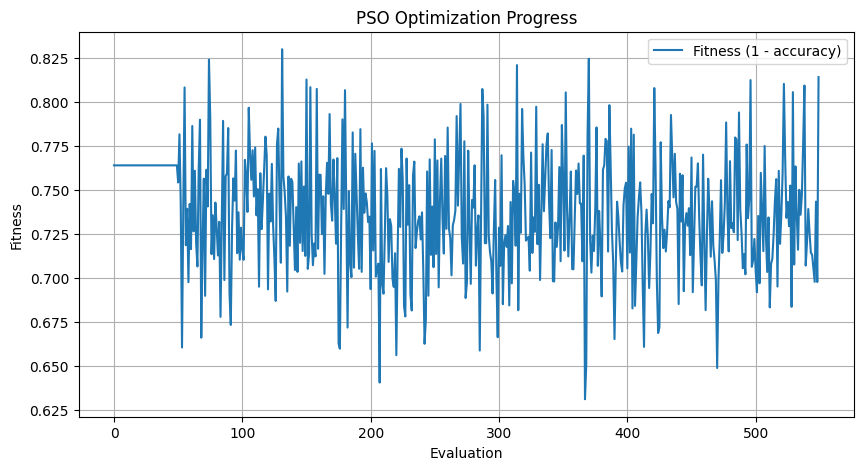

In [30]:
print(X_selected) 
print(best_fitness)
print(best_weights.shape)

#print(f"Number of selected features: {X_selected.shape[1]}")
#Plot the progress of the PSO optimization
plt.figure(figsize=(10, 5))
plt.plot(progress, label='Fitness (1 - accuracy)')
plt.xlabel('Evaluation')
plt.ylabel('Fitness')
plt.title('PSO Optimization Progress')
plt.legend()
plt.grid()
plt.savefig('pso_optimization_progress.png')
plt.show()



Loading DNA methylation data...


/Users/leandro/master/Mamo.IA/helpers/datasetHelper.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257

Data loaded successfully.
Threshold=0.9, selected 1383 features


/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


All features → Test Accuracy: 0.7468354430379747
All features → Test F1 (weighted): 0.7585263846458967
All features → Kappa index: 0.4817973105936373


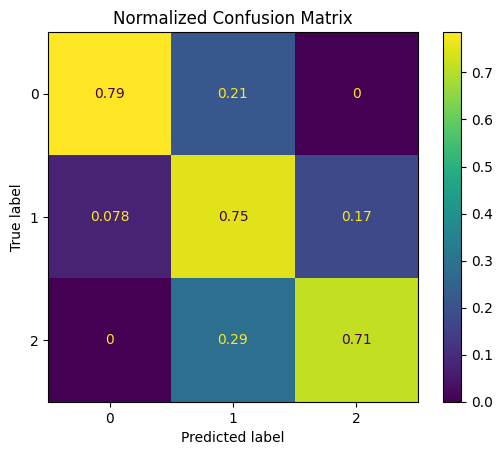

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


X, Y, columns = load_methylation_data(data_path)
print("Data loaded successfully.")
# Fill missing values with the lowest value of its cpg site
X = X.apply(lambda col: col.fillna(col.min()), axis=0)

# select features with PSO weight > 0.9
mask = best_weights > 0.99
X_selected = X.iloc[:, mask]
# how many features we kept
print(f"Threshold=0.9, selected {X_selected.shape[1]} features")

# 1) evaluate with all features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
# Apply SMOTE to balance the training instances
smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
X_train_all, y_train_all = smote.fit_resample(X_train_all, y_train_all)

clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_all, y_train_all)
y_pred_all = clf.predict(X_test_all)
y_pred_all_proba = clf.predict_proba(X_test_all)

print("All features → Test Accuracy:", accuracy_score(y_test_all, y_pred_all))
print("All features → Test F1 (weighted):", f1_score(y_test_all, y_pred_all, average='weighted'))

# Compute Kappa index for all features
kappa_all = cohen_kappa_score(y_test_all, y_pred_all)
print("All features → Kappa index:", kappa_all)

#2) Confusion matrices side by side
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_all, y_test_all, normalize='true')
disp.ax_.set_title("Normalized Confusion Matrix")
plt.show()

/Users/leandro/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selected features → Test Accuracy: 0.7531645569620253
Selected features → Test F1 (weighted): 0.7652147630120819
Selected features → Kappa index: 0.4966508740401896


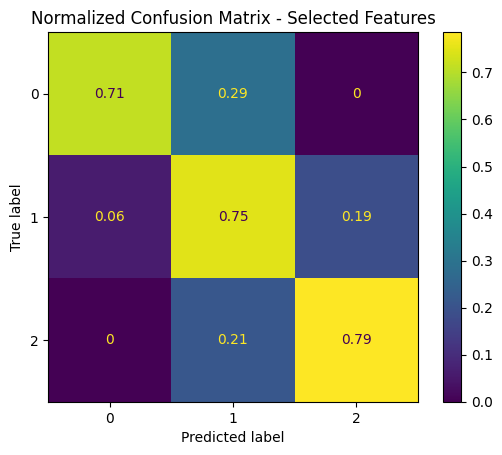

In [76]:
# 1) evaluate with selected features
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, Y, test_size=0.2, random_state=42
)
# Apply SMOTE to balance the training instances
smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
X_train_sel, y_train_sel = smote.fit_resample(X_train_sel, y_train_sel)

clf_sel = RandomForestClassifier(n_estimators=500, random_state=42)
clf_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = clf_sel.predict(X_test_sel)
y_pred_sel_proba = clf_sel.predict_proba(X_test_sel)

print("Selected features → Test Accuracy:", accuracy_score(y_test_sel, y_pred_sel))
print("Selected features → Test F1 (weighted):", f1_score(y_test_sel, y_pred_sel, average='weighted'))

# Compute Kappa index for selected features
kappa_sel = cohen_kappa_score(y_test_sel, y_pred_sel)
print("Selected features → Kappa index:", kappa_sel)

# Confusion matrix for selected features
disp_sel = ConfusionMatrixDisplay.from_estimator(clf_sel, X_test_sel, y_test_sel, normalize='true')
disp_sel.ax_.set_title("Normalized Confusion Matrix - Selected Features")
plt.show()


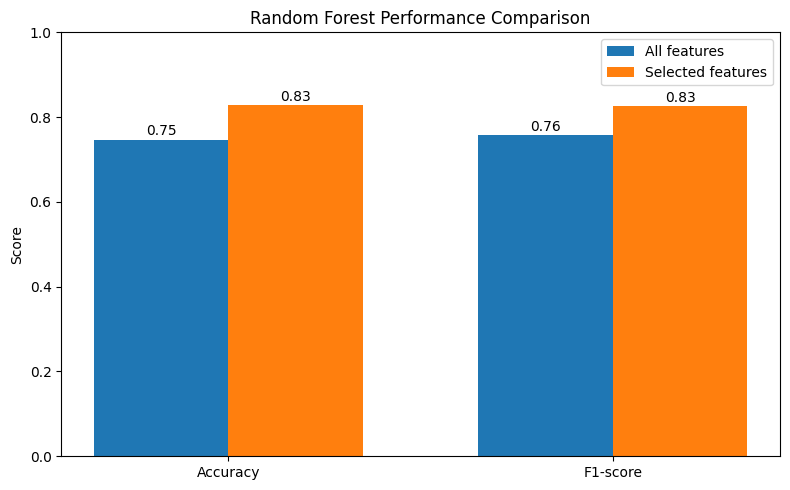

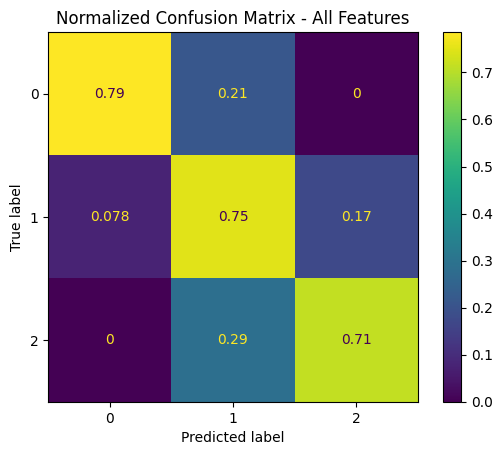

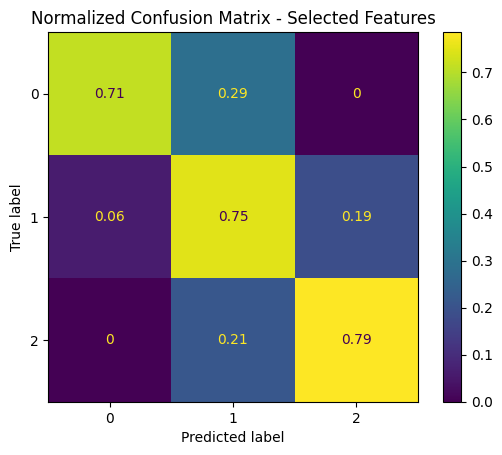

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Compute performance metrics
acc_all = accuracy_score(y_test_all, y_pred_all)
f1_all = f1_score(y_test_all, y_pred_all, average='weighted')

acc_sel = accuracy_score(y_test, y_pred)
f1_sel = f1_score(y_test, y_pred, average='weighted')

# 1) Bar chart: Accuracy vs F1-score for all vs selected features
labels = ['Accuracy', 'F1-score']
all_vals = [acc_all, f1_all]
sel_vals = [acc_sel, f1_sel]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, all_vals, width, label='All features', color='C0')
rects2 = ax.bar(x + width/2, sel_vals, width, label='Selected features', color='C1')
ax.set_ylabel('Score')
ax.set_title('Random Forest Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)
ax.legend()
for rect in rects1 + rects2:
    h = rect.get_height()
    ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                xytext=(0,3), textcoords="offset points", ha='center')
plt.tight_layout()
plt.show()


#2) Confusion matrices side by side
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_all, y_test_all, normalize='true')
disp.ax_.set_title("Normalized Confusion Matrix - All Features")
plt.show()


disp_sel = ConfusionMatrixDisplay.from_estimator(clf_sel, X_test_sel, y_test_sel, normalize='true')
disp_sel.ax_.set_title("Normalized Confusion Matrix - Selected Features")
plt.show()



In [79]:
# Compute and print the top 50 feature importances from the last RandomForestClassifier
feat_imp = pd.Series(clf_sel.feature_importances_, index=X_selected.columns)
top50 = feat_imp.sort_values(ascending=False).head(50)

print("Top 50 feature importances:")
# Print the top 50 importances using the actual feature names
for idx, imp in top50.items():
    feat_name = feature_names[int(idx)]
    print(f"{feat_name}: {imp:.4f}")


Top 50 feature importances:
cg07614786: 0.0136
cg19216044: 0.0128
cg21968796: 0.0122
cg19780563: 0.0111
cg19233923: 0.0111
cg20795863: 0.0104
cg21457147: 0.0099
cg23617121: 0.0096
cg23953133: 0.0093
cg23855818: 0.0089
cg05679613: 0.0084
cg01568736: 0.0083
cg07643942: 0.0076
cg17423978: 0.0073
cg14108394: 0.0073
cg05393484: 0.0072
cg25274750: 0.0071
cg26112901: 0.0071
cg03740984: 0.0070
cg26532905: 0.0070
cg14643520: 0.0070
cg07820214: 0.0069
cg18879041: 0.0069
cg12285118: 0.0069
cg03644378: 0.0068
cg12753858: 0.0068
cg04737405: 0.0066
cg01705458: 0.0064
cg17803430: 0.0064
cg03077492: 0.0063
cg20932053: 0.0062
cg15997411: 0.0061
cg21409833: 0.0059
cg10728503: 0.0059
cg24278076: 0.0059
cg17767931: 0.0059
cg05668720: 0.0058
cg22598744: 0.0058
cg14353201: 0.0057
cg22197708: 0.0056
cg10872447: 0.0054
cg00795268: 0.0054
cg27239157: 0.0053
cg05921699: 0.0053
cg09555679: 0.0053
cg27609819: 0.0053
cg12804976: 0.0051
cg25363317: 0.0048
cg18384643: 0.0047
cg02633817: 0.0046


In [ ]:
print(y_test_all[0:10])
print(y_pred_all[0:10])


[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 2]


In [71]:
from sklearn.metrics import roc_curve, auc, cohen_kappa_score

# Compute ROC curve and AUC for all features
# Compute ROC curve and AUC for all features (using probabilities for the positive class)
# Compute ROC curve and AUC for all features (using probabilities for the positive class)
fpr_all, tpr_all, _ = roc_curve(y_test_all, y_pred_all_proba[:, 1])
roc_auc_all = auc(fpr_all, tpr_all)

# Compute ROC curve and AUC for selected features (using probabilities for the positive class)
fpr_sel, tpr_sel, _ = roc_curve(y_test_sel, y_pred_sel_proba[:, 1])
roc_auc_sel = auc(fpr_sel, tpr_sel)



# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_all, tpr_all, color='blue', label=f'All Features (AUC = {roc_auc_all:.2f})')
plt.plot(fpr_sel, tpr_sel, color='green', label=f'Selected Features (AUC = {roc_auc_sel:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print Kappa indices
print(f"Kappa Index (All Features): {kappa_all:.2f}")
print(f"Kappa Index (Selected Features): {kappa_sel:.2f}")

ValueError: multiclass format is not supported